In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torchvision.transforms.functional as TF
import random
import torch.nn as nn

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
from tqdm import tqdm

from dataset import GTA

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
scaling_factor = 2
crop_size = 96*scaling_factor

lr_img_type = '[0, 1]' #'gta-small-norm'
hr_img_type = '[0, 1]'

batch_size = 64
epochs = 2
lr = 1e-4
#grad_clip = None

train_path = 'data/GTAV/small/'
training_data = GTA(train_path,'train',crop_size, scaling_factor,lr_img_type,hr_img_type, same_size_input=False)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_Data = GTA(train_path,'test',crop_size, scaling_factor,lr_img_type,hr_img_type, same_size_input=False)
test_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [5]:
# batch = next(iter(test_dataloader))
# print(len(batch))
# plt.imshow(batch[0][0].permute(1, 2, 0))
# plt.show()
# plt.imshow(batch[1][0].permute(1, 2, 0))
# plt.show()
# print(batch[0][0].shape, batch[1][0].shape)

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.max_pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.concat_conv = ConvBlock(in_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)  # Concatenate along the channel dimension
        x = self.concat_conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_classes, img_channels, initial_depth = 16, height=5):
        super(UNet, self).__init__()
        self.height = height

        # List of encoders
        self.encoders = nn.ModuleList()

        current_channels = initial_depth
        previous_channels = img_channels
        for _ in range(height-1):
            self.encoders.append(EncoderBlock(previous_channels, current_channels))
            previous_channels = current_channels
            current_channels *= 2

        # Bottleneck
        self.bottleneck = ConvBlock(previous_channels, current_channels)

        # List of decoders
        self.decoders = nn.ModuleList()
        for _ in range(height - 1):
            previous_channels = current_channels
            current_channels //= 2
            self.decoders.append(DecoderBlock(previous_channels, current_channels, current_channels))

        self.upconv = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.prefinal_conv = ConvBlock(initial_depth, initial_depth//2)

        # Final convolution layer
        self.final_conv = nn.Conv2d(initial_depth//2, n_classes, kernel_size=1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder path
        c = []
        for i in range(self.height-1):
            c_i, x = self.encoders[i](x)
            c.append(c_i)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        for i in range(self.height-1):
            x = self.decoders[i](x, c[-(i + 1)])

        x = self.upconv(x)
        x = self.prefinal_conv(x)

        # Final output
        output = self.final_conv(x)
        return output



In [13]:
torch.cuda.empty_cache()
model = UNet(n_classes=3, img_channels=3, initial_depth=24).to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [14]:
from torchsummary import summary

summary(model, (3, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 192, 192]             672
              ReLU-2         [-1, 24, 192, 192]               0
            Conv2d-3         [-1, 24, 192, 192]           5,208
              ReLU-4         [-1, 24, 192, 192]               0
         ConvBlock-5         [-1, 24, 192, 192]               0
         MaxPool2d-6           [-1, 24, 96, 96]               0
      EncoderBlock-7  [[-1, 24, 192, 192], [-1, 24, 96, 96]]               0
            Conv2d-8           [-1, 48, 96, 96]          10,416
              ReLU-9           [-1, 48, 96, 96]               0
           Conv2d-10           [-1, 48, 96, 96]          20,784
             ReLU-11           [-1, 48, 96, 96]               0
        ConvBlock-12           [-1, 48, 96, 96]               0
        MaxPool2d-13           [-1, 48, 48, 48]               0
     EncoderBlock-14  [[-1

In [16]:
losses = []

In [28]:
criterion = nn.MSELoss().to(device)
start_epoch = 0

epochs = 20
for epoch in range(epochs):
    print("EPOCH",epoch+start_epoch+1)
    running_loss = 0
    print_freq = 20
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1+start_epoch}/{epochs+start_epoch}")
    for i,(lr_imgs, hr_imgs) in enumerate(loop):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()

        # # Clip gradients, if necessary
        # if grad_clip is not None:
        #     clip_gradient(optimizer, grad_clip)

        optimizer.step()
        running_loss += loss.item()
        if i % print_freq==print_freq-1:
            current_loss = running_loss / print_freq
            losses.append(current_loss)
            running_loss = 0

            loop.set_postfix(loss=current_loss)


EPOCH 1


Epoch 1/20: 100%|██████████| 40/40 [00:42<00:00,  1.07s/it, loss=0.00261]


EPOCH 2


Epoch 2/20: 100%|██████████| 40/40 [00:43<00:00,  1.10s/it, loss=0.00228]


EPOCH 3


Epoch 3/20: 100%|██████████| 40/40 [00:47<00:00,  1.18s/it, loss=0.00231]


EPOCH 4


Epoch 4/20: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it, loss=0.00198]


EPOCH 5


Epoch 5/20: 100%|██████████| 40/40 [00:50<00:00,  1.25s/it, loss=0.00195]


EPOCH 6


Epoch 6/20: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it, loss=0.00205]


EPOCH 7


Epoch 7/20: 100%|██████████| 40/40 [00:47<00:00,  1.19s/it, loss=0.00191]


EPOCH 8


Epoch 8/20: 100%|██████████| 40/40 [00:47<00:00,  1.19s/it, loss=0.00188]


EPOCH 9


Epoch 9/20: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it, loss=0.00177]


EPOCH 10


Epoch 10/20: 100%|██████████| 40/40 [00:50<00:00,  1.26s/it, loss=0.0019] 


EPOCH 11


Epoch 11/20: 100%|██████████| 40/40 [00:48<00:00,  1.21s/it, loss=0.00178]


EPOCH 12


Epoch 12/20: 100%|██████████| 40/40 [00:50<00:00,  1.26s/it, loss=0.00178]


EPOCH 13


Epoch 13/20: 100%|██████████| 40/40 [00:52<00:00,  1.32s/it, loss=0.00169]


EPOCH 14


Epoch 14/20:  70%|███████   | 28/40 [00:38<00:16,  1.37s/it, loss=0.00184]


KeyboardInterrupt: 

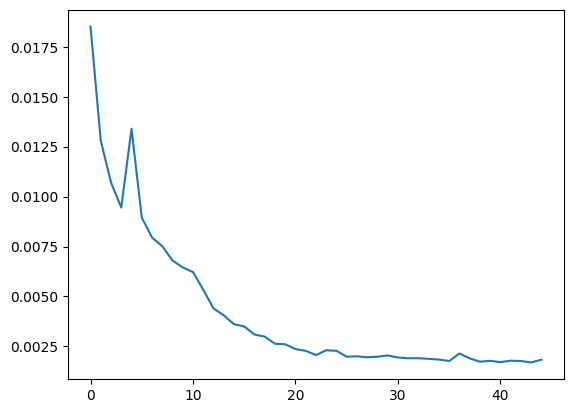

In [29]:
plt.plot(losses[2:])
plt.show()

In [30]:
len(losses)

47

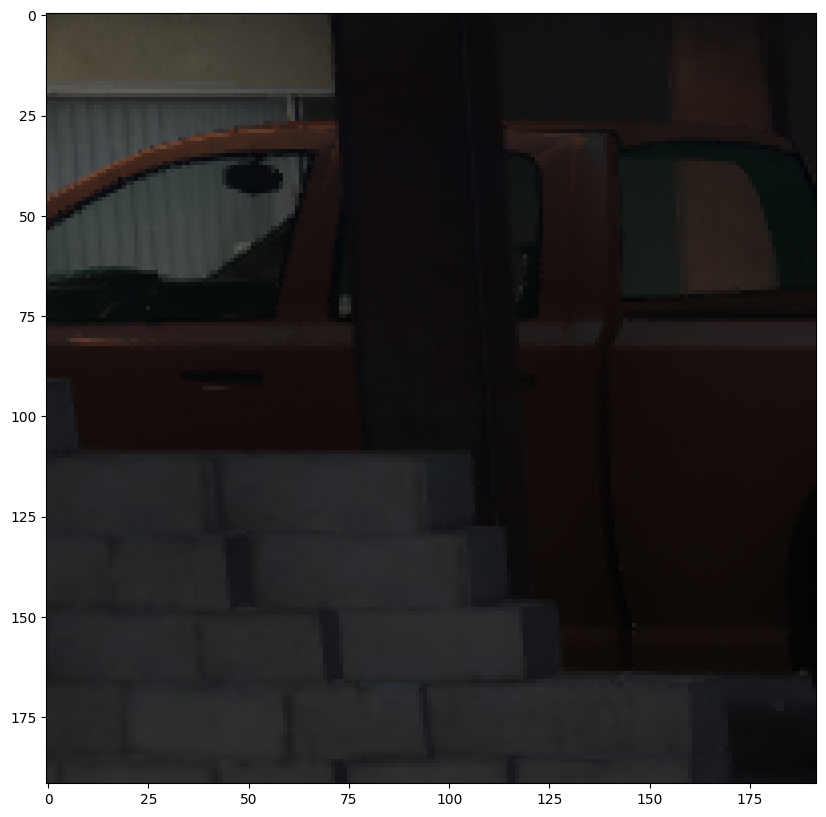

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


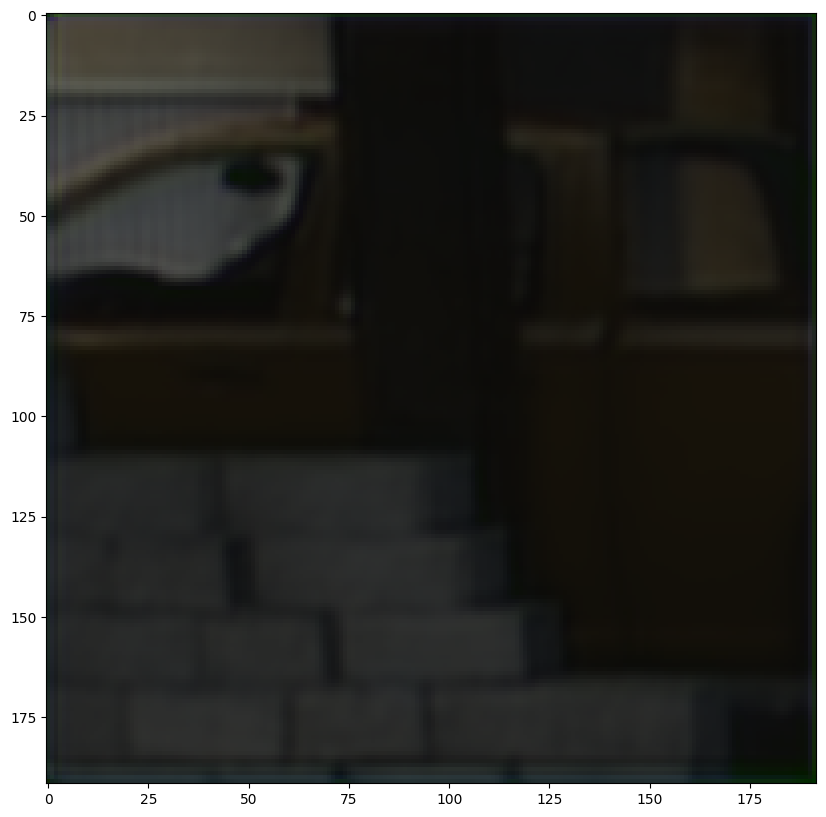

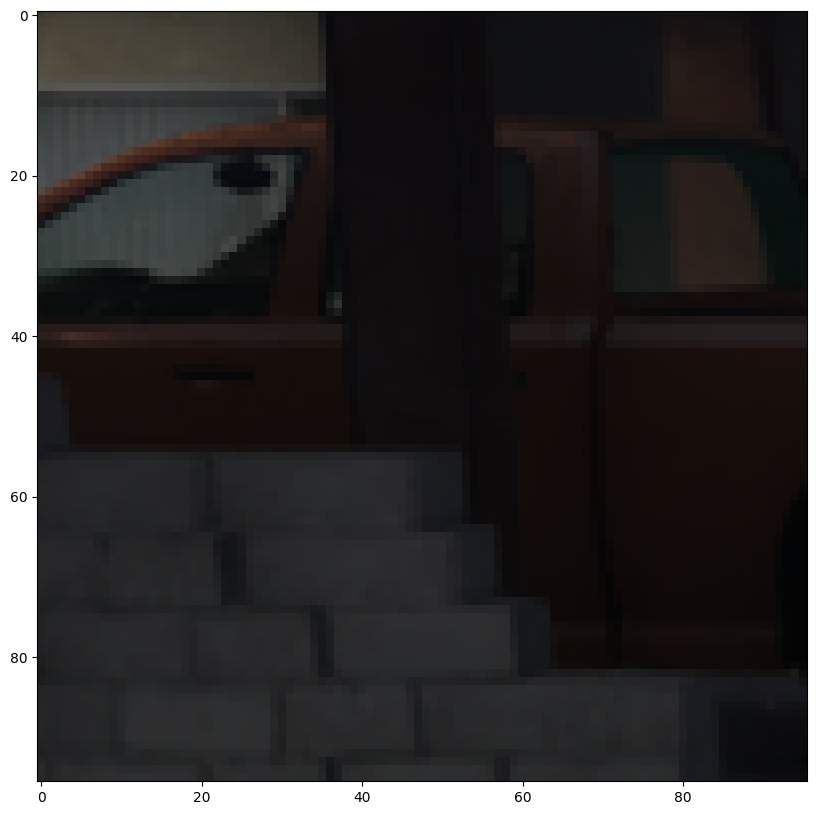

(192, 192, 3) (96, 96, 3) (192, 192, 3)


In [31]:
with torch.no_grad():
    for lr_img, hr_img in training_data:
        model.eval()
        sr_img = model(lr_img.unsqueeze(0).to(device)).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
        # plt.imshow(np.concatenate([sr_img, (hr_img).permute(1, 2, 0).numpy()], axis=1))
        # plt.show()
        size = (10,10)
        plt.figure(figsize=size)
        plt.imshow((hr_img).permute(1, 2, 0).numpy())
        plt.show()
        plt.figure(figsize=size)
        plt.imshow(sr_img)
        plt.show()
        plt.figure(figsize=size)
        plt.imshow((lr_img).permute(1, 2, 0).numpy())
        plt.show()
        print(sr_img.shape, (lr_img).permute(1, 2, 0).numpy().shape, (hr_img).permute(1, 2, 0).numpy().shape)
        break

In [32]:
torch.save({'epoch': len(losses),
                    'model': model,
                    'optimizer': optimizer},
                   'checkpoint_Unet2.pth.tar')